# **Import Libraries + Configurations**

In [1]:
# =========
# Libraries
# =========

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import librosa
import librosa.display
import os
import json
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.model_selection import GroupShuffleSplit, train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F
from torch.utils.data import Dataset

# =======
# Configs
# =======

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


BATCH_SIZE = 64
NUM_CLASSES = 10
PATIENCE = 10
EPOCHS = 100

ROOT_DIR   = "/kaggle/working/preprocessed/features_mel"
META_PATH  = "/kaggle/input/birdclef-2024/train_metadata.csv"


DATA_DIR = Path('/kaggle/input/birdclef-2024')
OUT_DIR = Path('/kaggle/working/preprocessed')
OUT_DIR.mkdir(exist_ok=True, parents=True)

AUDIO_DIR = DATA_DIR / 'train_audio'

# Audio parameters
SR = 32000 # target sampling rate (samples per second).
TARGET_SEC = 5.0 # length (in seconds) each example should be (commonly used to pad / crop audio to fixed-size windows).

# spectrogram STFT parameters: N_FFT is the window size for each FFT, and HOP is the hop length (time step between frames).
N_FFT = 2048 # ~64ms window at 32k Hz
HOP = 512 # ~16ms step
N_MELS = 128 # number of Mel bands when computing Mel spectrograms; common input for audio models.

# Choose top classes
TOP_N = 10

# Dataset split proportions
TRAIN_PCT = 0.70
VAL_PCT   = 0.15
TEST_PCT  = 0.15

# Augmentation hyperparams
MAX_PITCH_STEPS = 2.0
STRETCH_MIN = 0.85
STRETCH_MAX = 1.15
NOISE_STD = 0.005

# **Load metadata + Choose Top-N classes**

In [2]:
df = pd.read_csv(DATA_DIR / 'train_metadata.csv')

counts = df['primary_label'].value_counts() # By default value_counts sorts descendingly.

print("Total species:", df['primary_label'].nunique())
print("\nTop 30 species by frequency:")
print(counts.head(30))

Total species: 182

Top 30 species by frequency:
primary_label
hoopoe     500
grewar3    500
houspa     500
blrwar1    500
grnsan     500
comgre     500
graher1    500
litgre1    500
eurcoo     500
comkin1    500
lirplo     500
eucdov     500
eaywag1    500
woosan     500
zitcis1    500
barswa     500
bcnher     500
comros     500
commoo3    500
grywag     500
comsan     500
bkwsti     500
rorpar     420
litegr     405
comtai1    302
grtdro1    278
greegr     276
asikoe2    275
purher1    274
wemhar1    273
Name: count, dtype: int64


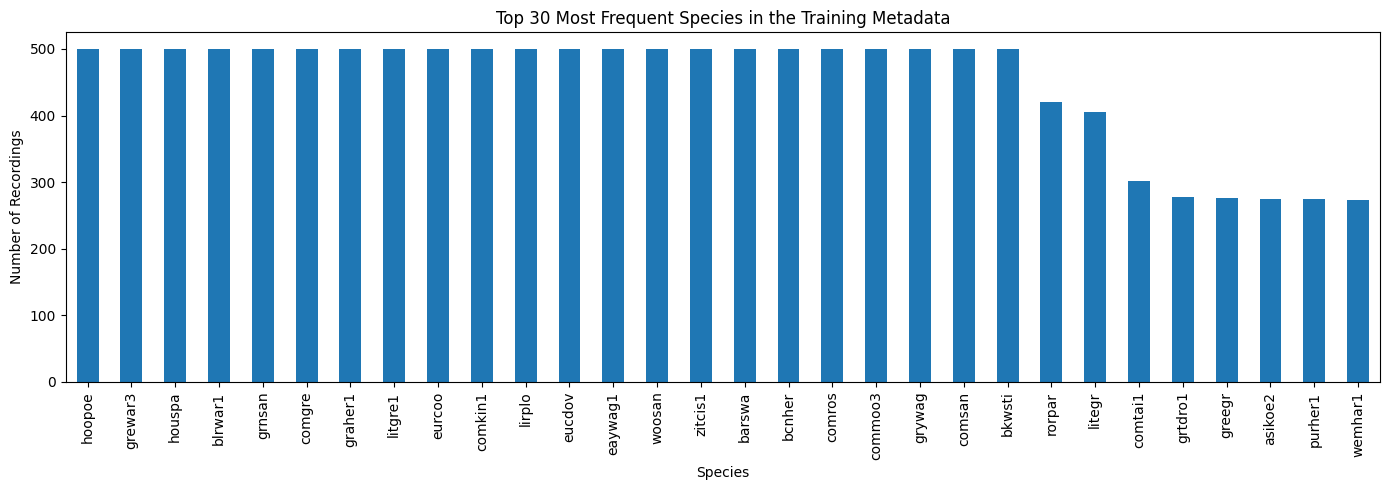

In [3]:
top30 = counts.head(30)

plt.figure(figsize=(14, 5))
top30.plot(kind='bar')
plt.title("Top 30 Most Frequent Species in the Training Metadata")
plt.xlabel("Species")
plt.ylabel("Number of Recordings")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

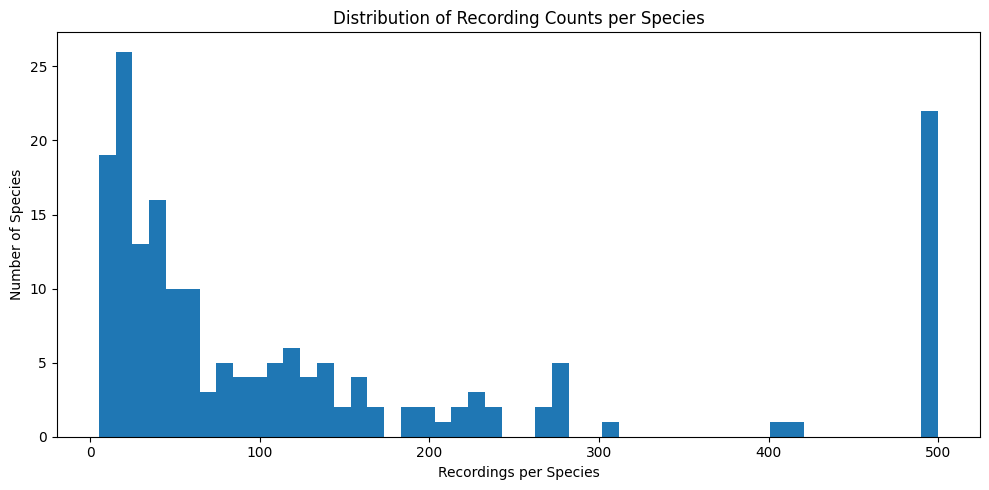

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(counts.values, bins=50)
plt.title("Distribution of Recording Counts per Species")
plt.xlabel("Recordings per Species")
plt.ylabel("Number of Species")
plt.tight_layout()
plt.show()

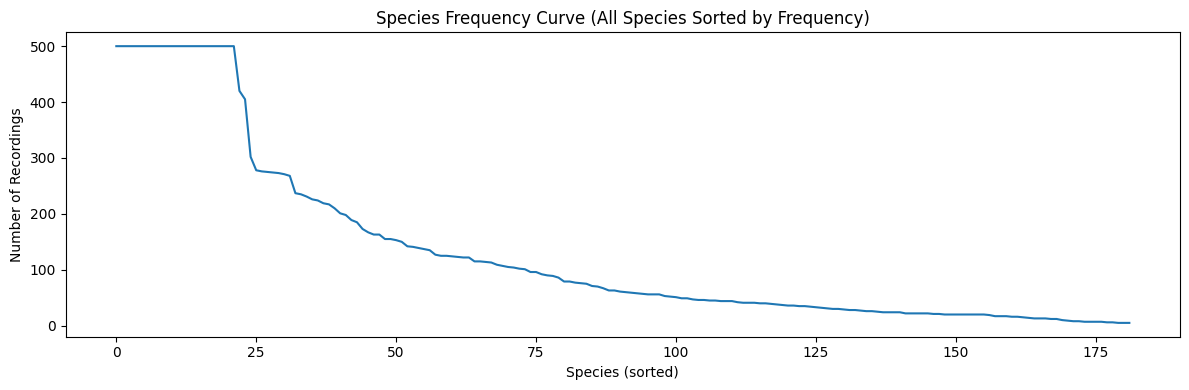

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(counts.values)
plt.title("Species Frequency Curve (All Species Sorted by Frequency)")
plt.xlabel("Species (sorted)")
plt.ylabel("Number of Recordings")
plt.tight_layout()
plt.show()

In [6]:
# Select the TOP_N most common species

# takes the top TOP_N most frequent species and stores their label names in selected.
selected = counts.head(TOP_N).index.tolist()
print(f"\nSelected top-{TOP_N} species: {selected}")

# Filter metadata to only include these classes
filtered = df[df['primary_label'].isin(selected)].copy()

# filtered['filename'].notna() removes rows where filename is missing.
filtered = filtered[filtered['filename'].notna()].reset_index(drop=True) 

print("\nFiltered shape:", filtered.shape)
print("\nClass distribution in filtered:")
print(filtered['primary_label'].value_counts())


Selected top-10 species: ['hoopoe', 'grewar3', 'houspa', 'blrwar1', 'grnsan', 'comgre', 'graher1', 'litgre1', 'eurcoo', 'comkin1']

Filtered shape: (5000, 12)

Class distribution in filtered:
primary_label
blrwar1    500
comgre     500
comkin1    500
eurcoo     500
graher1    500
grewar3    500
grnsan     500
hoopoe     500
houspa     500
litgre1    500
Name: count, dtype: int64


# **Check missing files**

In [7]:
missing = []
for fn in filtered['filename'].unique():
    if not (AUDIO_DIR / fn).exists():
        missing.append(fn)

print("Missing audio files:", len(missing))
if len(missing) > 0:
    print("Example missing:", missing[:10])
else:
    print("All audio files found.")

Missing audio files: 0
All audio files found.


# **Data Splitting based on Groups ("Author")**

# **Compute group IDs**

**This constructs an array called groups that will be used to split the data while keeping samples from the same group together (so the same author doesn’t appear in both train and validation sets). If author is missing, filename is used as a fallback group id. Group-aware splitting prevents data leakage when multiple examples from the same real-world source exist. GroupShuffleSplit (imported earlier) is the tool you’d typically use to perform such group-based splits. 
Scikit-learn**

In [8]:
# Use 'author' to avoid leakage between train/val/test, If author is missing, use filename as fallback.

groups = filtered['author'].fillna(filtered['filename']).values
print("Example groups:", groups[:10])

Example groups: ['Patrik Åberg' 'Edmunds Racinskis' 'Edmunds Racinskis'
 'Edmunds Racinskis' 'Antero Lindholm' 'Patrick Franke' 'Patrick Franke'
 'Lars Theng' 'Antero Lindholm' 'Albert Lastukhin']


# **Split 1: TrainVal / Test**

In [9]:
splitter1 = GroupShuffleSplit(
    n_splits=1, 
    test_size=TEST_PCT, 
    random_state=SEED
)

trainval_idx, test_idx = next(
    splitter1.split(
        filtered,
        filtered['primary_label'],
        groups
    )
)

trainval_df = filtered.iloc[trainval_idx].reset_index(drop=True)
test_df     = filtered.iloc[test_idx].reset_index(drop=True)

In [10]:
print("TrainVal shape:", trainval_df.shape)
print("Test shape:", test_df.shape)

TrainVal shape: (4005, 12)
Test shape: (995, 12)


# **Split 2: Train / Validation**

In [10]:
# val proportion relative to TrainVal only
val_rel = VAL_PCT / (1.0 - TEST_PCT)

splitter2 = GroupShuffleSplit(
    n_splits=1, 
    test_size=val_rel, 
    random_state=SEED
)

groups_trainval = trainval_df['author'].fillna(trainval_df['filename']).values

train_idx_rel, val_idx_rel = next(
    splitter2.split(
        trainval_df,
        trainval_df['primary_label'],
        groups_trainval
    )
)

train_df = trainval_df.iloc[train_idx_rel].reset_index(drop=True)
val_df   = trainval_df.iloc[val_idx_rel].reset_index(drop=True)

In [11]:
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

Train shape: (3037, 12)
Val shape: (968, 12)


# **Save splits + sanity checks**

In [12]:
train_df.to_csv(OUT_DIR / 'train_meta_top10.csv', index=False)
val_df.to_csv(OUT_DIR / 'val_meta_top10.csv', index=False)
test_df.to_csv(OUT_DIR / 'test_meta_top10.csv', index=False)

In [13]:
print("Saved train/val/test metadata!")

print("\nPer-class counts — TRAIN:")
print(train_df['primary_label'].value_counts().sort_index())

print("\nPer-class counts — VALIDATION:")
print(val_df['primary_label'].value_counts().sort_index())

print("\nPer-class counts — TEST:")
print(test_df['primary_label'].value_counts().sort_index())

# Makeup check
print("\nCheck total rows:",
      len(train_df) + len(val_df) + len(test_df),
      "== filtered size:", len(filtered))

Saved train/val/test metadata!

Per-class counts — TRAIN:
primary_label
blrwar1    349
comgre     322
comkin1    220
eurcoo     325
graher1    319
grewar3    363
grnsan     311
hoopoe     257
houspa     250
litgre1    321
Name: count, dtype: int64

Per-class counts — VALIDATION:
primary_label
blrwar1     60
comgre      80
comkin1    178
eurcoo      72
graher1     98
grewar3     53
grnsan     106
hoopoe     123
houspa     121
litgre1     77
Name: count, dtype: int64

Per-class counts — TEST:
primary_label
blrwar1     91
comgre      98
comkin1    102
eurcoo     103
graher1     83
grewar3     84
grnsan      83
hoopoe     120
houspa     129
litgre1    102
Name: count, dtype: int64

Check total rows: 5000 == filtered size: 5000


# **Preprocess + Feature Extraction**

In [14]:
def load_and_fix_length(path, sr=SR, target_sec=TARGET_SEC):
    y, _sr = sf.read(path)
    # Reads the audio file at path into a NumPy array y and returns the file’s original sample rate _sr.
    
    # Convert to mono (from 2 channels to one channel)
    if y.ndim > 1:
        # y = y.mean(axis=1)
        y = librosa.to_mono(y.T) # y.T converts from (n_samples, n_channels) → (n_channels, n_samples),
    
    # Resample the waveform to sr (32000)
    if _sr != sr:
        y = librosa.resample(y.astype('float32'), orig_sr=_sr, target_sr=sr)
    
    # Compute the target number of samples (32000 * 5 = 160000 samples).
    target_len = int(sr * target_sec)

    
    # Padding short audio with zeros at the end so every clip becomes target_len.
    if len(y) < target_len:
        pad = target_len - len(y)
        y = np.pad(y, (0, pad), mode='constant')
        
    elif len(y) > target_len:  # Random Crop long audio for variability
        start = np.random.randint(0, len(y)-target_len+1)
        y = y[start:start+target_len]

    
    # RMS normalization
    rms = np.sqrt(np.mean(y**2)) + 1e-9 # Adding 1e-9 prevents division by zero for silent files.
    y = y / rms
    return y.astype('float32')

In [15]:
def extract_log_mel(y, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS):
    # Mel scale compresses frequency bins to match human perception and is the standard input for many audio NN models.
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    
    # librosa.power_to_db converts the power spectrogram to decibels (log scale), which both compresses dynamic
    # range and tends to work better for models than linear power.
    # It computes 10 * log10(S / ref) in a numerically stable way.
    logS = librosa.power_to_db(S, ref=np.max)
    return logS.astype('float32')

# **Extract original TRAIN log-mels directly into features_mel/Train**

In [16]:
# Ensure necessary vars exist
if 'train_df' not in globals():
    train_df = pd.read_csv(OUT_DIR / 'train_meta_top10.csv')

FEAT_DIR = OUT_DIR / 'features_mel'
train_dir = FEAT_DIR / 'Train'
for d in (FEAT_DIR, train_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

orig_feat_csv = OUT_DIR / 'train_features_top10_original.csv'
orig_feat_records = []

if orig_feat_csv.exists():
    print("Original features CSV found — loading:", orig_feat_csv)
    orig_feat_df = pd.read_csv(orig_feat_csv)
    print("Rows loaded:", len(orig_feat_df))
else:
    print("No original features CSV found — extracting log-mel for train samples now...")
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
        fn = row['filename']
        path = AUDIO_DIR / fn
        try:
            y = load_and_fix_length(path)   # uses your existing helper
            m = extract_log_mel(y)          # uses your existing helper
            out_filename = Path(fn).stem + '.npy'
            out_path = train_dir / out_filename
            # skip if file already exists (idempotent)
            if not out_path.exists():
                np.save(out_path, m)
            orig_feat_records.append({
                'feature_path': str(out_path),
                'filename': fn,
                'primary_label': row['primary_label'],
                'is_augmented': 0
            })
        except Exception as e:
            print("Error on", fn, e)

    orig_feat_df = pd.DataFrame(orig_feat_records)
    orig_feat_df.to_csv(orig_feat_csv, index=False)
    print("Saved original train features metadata:", orig_feat_csv)
    print("Original train feature rows:", len(orig_feat_df))

No original features CSV found — extracting log-mel for train samples now...


  0%|          | 0/3037 [00:00<?, ?it/s]

Saved original train features metadata: /kaggle/working/preprocessed/train_features_top10_original.csv
Original train feature rows: 3037


# **Extract VALIDATION and TEST log-mels into separate subfolders**

In [17]:
# Ensure val_df / test_df present
assert 'val_df' in globals(), "val_df not found — run the split cells first"
assert 'test_df' in globals(), "test_df not found — run the split cells first"

FEAT_DIR = OUT_DIR / 'features_mel'
val_dir = FEAT_DIR / 'Validation'
test_dir = FEAT_DIR / 'Test'
for d in (FEAT_DIR, val_dir, test_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

# Validation
val_records = []
print("Extracting log-mel for validation set... total rows:", len(val_df))
for idx, row in tqdm(val_df.iterrows(), total=len(val_df)):
    fn = row['filename']
    path = AUDIO_DIR / fn
    try:
        y = load_and_fix_length(path)
        m = extract_log_mel(y)
        out_name = f"{Path(fn).stem}_VAL.npy"
        out_path = val_dir / out_name
        if not out_path.exists():
            np.save(out_path, m)
        val_records.append({
            'feature_path': str(out_path),
            'filename': fn,
            'primary_label': row['primary_label'],
            'is_augmented': 0
        })
    except Exception as e:
        print("Error processing validation file:", fn, e)

val_feat_df = pd.DataFrame(val_records)
val_csv = OUT_DIR / 'val_features_top10.csv'
val_feat_df.to_csv(val_csv, index=False)
print("Saved validation features CSV:", val_csv)
print("Validation features extracted:", len(val_feat_df))

# Test
test_records = []
print("Extracting log-mel for test set... total rows:", len(test_df))
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    fn = row['filename']
    path = AUDIO_DIR / fn
    try:
        y = load_and_fix_length(path)
        m = extract_log_mel(y)
        out_name = f"{Path(fn).stem}_TEST.npy"
        out_path = test_dir / out_name
        if not out_path.exists():
            np.save(out_path, m)
        test_records.append({
            'feature_path': str(out_path),
            'filename': fn,
            'primary_label': row['primary_label'],
            'is_augmented': 0
        })
    except Exception as e:
        print("Error processing test file:", fn, e)

test_feat_df = pd.DataFrame(test_records)
test_csv = OUT_DIR / 'test_features_top10.csv'
test_feat_df.to_csv(test_csv, index=False)
print("Saved test features CSV:", test_csv)
print("Test features extracted:", len(test_feat_df))

Extracting log-mel for validation set... total rows: 968


  0%|          | 0/968 [00:00<?, ?it/s]

Saved validation features CSV: /kaggle/working/preprocessed/val_features_top10.csv
Validation features extracted: 968
Extracting log-mel for test set... total rows: 995


  0%|          | 0/995 [00:00<?, ?it/s]

Saved test features CSV: /kaggle/working/preprocessed/test_features_top10.csv
Test features extracted: 995


# **Augmentation**

In [19]:
# Apply one random augmentation: pitch / stretch / noise.
# Uses explicit librosa.effects calls to avoid shadowing issues.
def augment_audio(y, sr=SR):
    choice = random.choice(['pitch', 'stretch', 'noise'])
    if choice == 'pitch':
        steps = random.uniform(-MAX_PITCH_STEPS, MAX_PITCH_STEPS)
        try:
            y_aug = librosa.effects.pitch_shift(y.astype('float32'), sr, steps)
        except Exception:
            return y
        # keep same length
        if len(y_aug) < len(y):
            y_aug = np.pad(y_aug, (0, len(y)-len(y_aug)), mode='constant')
        else:
            y_aug = y_aug[:len(y)]
        return y_aug.astype('float32')

    elif choice == 'stretch':
        rate = random.uniform(STRETCH_MIN, STRETCH_MAX)
        try:
            y_st = librosa.effects.time_stretch(y.astype('float32'), rate)
        except Exception:
            return y
        if len(y_st) < len(y):
            y_st = np.pad(y_st, (0, len(y)-len(y_st)), mode='constant')
        else:
            y_st = y_st[:len(y)]
        return y_st.astype('float32')

    else:  # noise
        noise = np.random.normal(0, NOISE_STD, size=len(y)).astype('float32')
        return (y + noise).astype('float32')

# **Augment TRAIN set directly into features_mel/Train, save balanced CSV and class weights**

In [42]:
# Ensure train_df & orig_feat_df
if 'train_df' not in globals():
    train_df = pd.read_csv(OUT_DIR / 'train_meta_top10.csv')

orig_csv = OUT_DIR / 'train_features_top10_original.csv'
if Path(orig_csv).exists():
    orig_feat_df = pd.read_csv(orig_csv)
else:
    # If original CSV missing (maybe you ran cell1 but didn't save), try to build from files in Train dir
    train_dir = OUT_DIR / 'features_mel' / 'Train'
    orig_feat_df = []
    for p in Path(train_dir).glob('*.npy'):
        # Try to recover label from train_df by filename match
        fname = p.name
        # find corresponding filename in train_df
        match = train_df[train_df['filename'].apply(lambda x: Path(x).stem in fname)]
        label = match['primary_label'].iloc[0] if len(match) > 0 else ''
        orig_feat_df.append({'feature_path': str(p), 'filename': fname, 'primary_label': label, 'is_augmented': 0})
    orig_feat_df = pd.DataFrame(orig_feat_df)

# Directories
FEAT_DIR = OUT_DIR / 'features_mel'
train_dir = FEAT_DIR / 'Train'
train_dir.mkdir(parents=True, exist_ok=True)

# Determine target per-class
train_class_counts = train_df['primary_label'].value_counts()
TARGET_PER_CLASS =500# int(train_class_counts.max())
# TARGET_PER_CLASS = 1000
print("Target per class (max in train):", TARGET_PER_CLASS)

# Current original feature counts
curr_counts = orig_feat_df['primary_label'].value_counts().to_dict()
print("\nCurrent extracted original counts (may be <= train counts):")
print(pd.Series(curr_counts).sort_index())

aug_records = []
classes = sorted(train_df['primary_label'].unique())

print(f"\nAugmenting train only to reach {TARGET_PER_CLASS} samples per class (based on train_df)...")
for cls in tqdm(classes):
    curr = int(curr_counts.get(cls, 0))
    needed = TARGET_PER_CLASS - curr
    if needed <= 0:
        continue

    candidates = train_df[train_df['primary_label'] == cls]
    if candidates.empty:
        print("No train candidates for", cls, " — skipping.")
        continue

    sampled = candidates.sample(needed, replace=True, random_state=SEED).reset_index(drop=True)
    for _, row in sampled.iterrows():
        wav_path = AUDIO_DIR / row['filename']
        try:
            y = load_and_fix_length(wav_path)
            y_aug = augment_audio(y, SR)
            mel = extract_log_mel(y_aug)
            aug_stem = f"{Path(row['filename']).stem}_AUG_{random.randint(100000, 999999)}.npy"
            out_path = train_dir / aug_stem
            # ensure unique (very unlikely conflict)
            if out_path.exists():
                continue
            np.save(out_path, mel)
            aug_records.append({
                'feature_path': str(out_path),
                'filename': row['filename'],
                'primary_label': cls,
                'is_augmented': 1
            })
        except Exception as e:
            print("Error augmenting", wav_path, e)

aug_df = pd.DataFrame(aug_records)
print("Augmented feature rows created:", len(aug_df))

# Combine original + augmented -> balanced features CSV
# Make sure orig_feat_df feature_path points to Train dir files (if they are by filename)
def normalize_feature_path(p):
    if pd.isna(p) or p == '':
        return p
    p = Path(p)
    if p.exists():
        return str(p)
    # try to resolve by name inside train_dir
    candidate = train_dir / p.name
    if candidate.exists():
        return str(candidate)
    return str(p)

if 'feature_path' in orig_feat_df.columns:
    orig_feat_df['feature_path'] = orig_feat_df['feature_path'].apply(normalize_feature_path)

final_feat_df = pd.concat([orig_feat_df, aug_df], ignore_index=True).reset_index(drop=True)
balanced_csv = OUT_DIR / 'train_features_top10_balanced_by_maxclass.csv'
final_feat_df.to_csv(balanced_csv, index=False)
print("Saved balanced train features metadata:", balanced_csv)

# Final counts check and class weights
final_counts = final_feat_df['primary_label'].value_counts().sort_index()
print("\nFinal per-class counts (train) after augmentation:")
print(final_counts)

total = final_counts.sum()
class_weight = {label: (total / (len(final_counts) * int(cnt))) for label, cnt in final_counts.items()}
with open(OUT_DIR / 'class_weights_top10_by_maxclass.json', 'w') as f:
    json.dump(class_weight, f)
print("Saved class weights:", OUT_DIR / 'class_weights_top10_by_maxclass.json')

# Quick final distribution and plot
def count_npys(d):
    return len(list(Path(d).glob('*.npy')))

print("\nFinal distribution in subfolders:")
print(f" Train: {count_npys(train_dir)} files -> {train_dir}")
print(f" Validation: {count_npys(FEAT_DIR / 'Validation')} files -> {FEAT_DIR / 'Validation'}")
print(f" Test: {count_npys(FEAT_DIR / 'Test')} files -> {FEAT_DIR / 'Test'}")

Target per class (max in train): 500

Current extracted original counts (may be <= train counts):
blrwar1    349
comgre     322
comkin1    220
eurcoo     325
graher1    319
grewar3    363
grnsan     311
hoopoe     257
houspa     250
litgre1    321
dtype: int64

Augmenting train only to reach 500 samples per class (based on train_df)...


  0%|          | 0/10 [00:00<?, ?it/s]

Augmented feature rows created: 1963
Saved balanced train features metadata: /kaggle/working/preprocessed/train_features_top10_balanced_by_maxclass.csv

Final per-class counts (train) after augmentation:
primary_label
blrwar1    500
comgre     500
comkin1    500
eurcoo     500
graher1    500
grewar3    500
grnsan     500
hoopoe     500
houspa     500
litgre1    500
Name: count, dtype: int64
Saved class weights: /kaggle/working/preprocessed/class_weights_top10_by_maxclass.json

Final distribution in subfolders:
 Train: 5593 files -> /kaggle/working/preprocessed/features_mel/Train
 Validation: 968 files -> /kaggle/working/preprocessed/features_mel/Validation
 Test: 995 files -> /kaggle/working/preprocessed/features_mel/Test


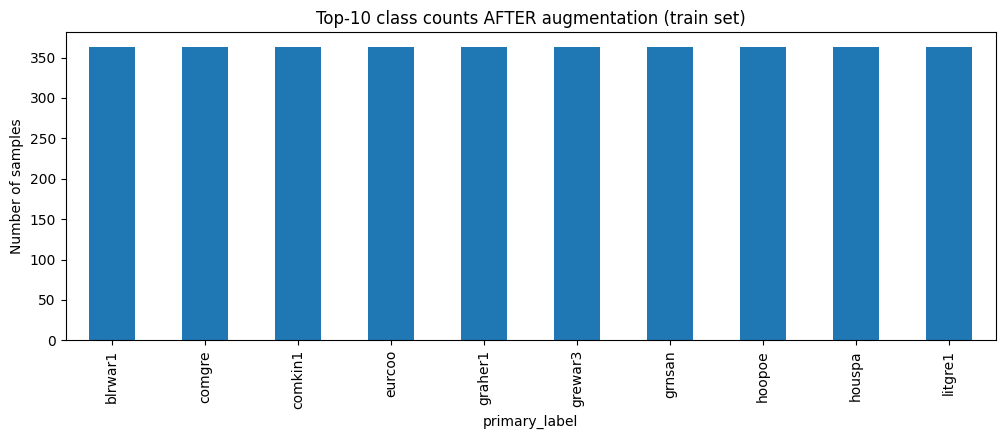

In [21]:
plt.figure(figsize=(12,4))
final_counts.sort_values(ascending=False).plot(kind='bar')
plt.title("Top-10 class counts AFTER augmentation (train set)")
plt.ylabel("Number of samples")
plt.xticks(rotation=90)
plt.show()

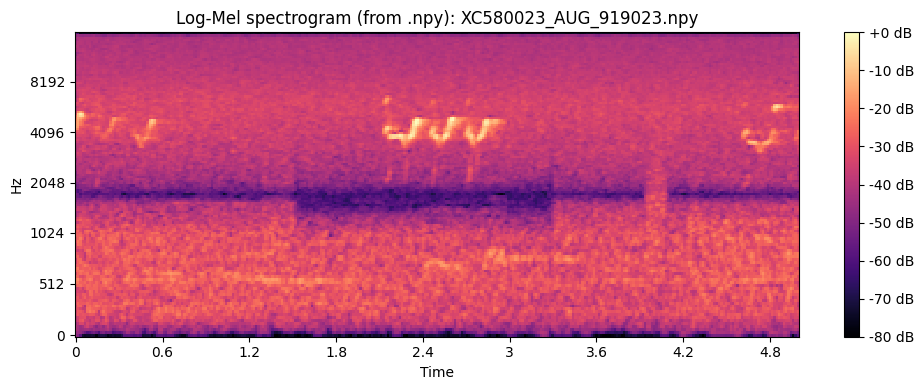

In [43]:
# adjust this to your features folder
# train_dir = Path('/kaggle/working/preprocessed/features_mel/Train')

# pick a random .npy
files = list(train_dir.glob('*.npy'))
assert len(files) > 0, "No .npy files found in train_dir"
p = random.choice(files)

# load mel (shape: n_mels x frames)
mel = np.load(p)

# compute time axis (seconds) for frames: frame_time = hop_length / sr
frame_times = np.arange(mel.shape[1]) * (HOP / SR)  # HOP and SR from your config

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel,
                         sr=SR,
                         hop_length=HOP,
                         x_axis='time',
                         y_axis='mel',
                         fmax=SR//2)
plt.colorbar(format='%+2.0f dB')
plt.title(f"Log-Mel spectrogram (from .npy): {p.name}")
plt.tight_layout()
plt.show()

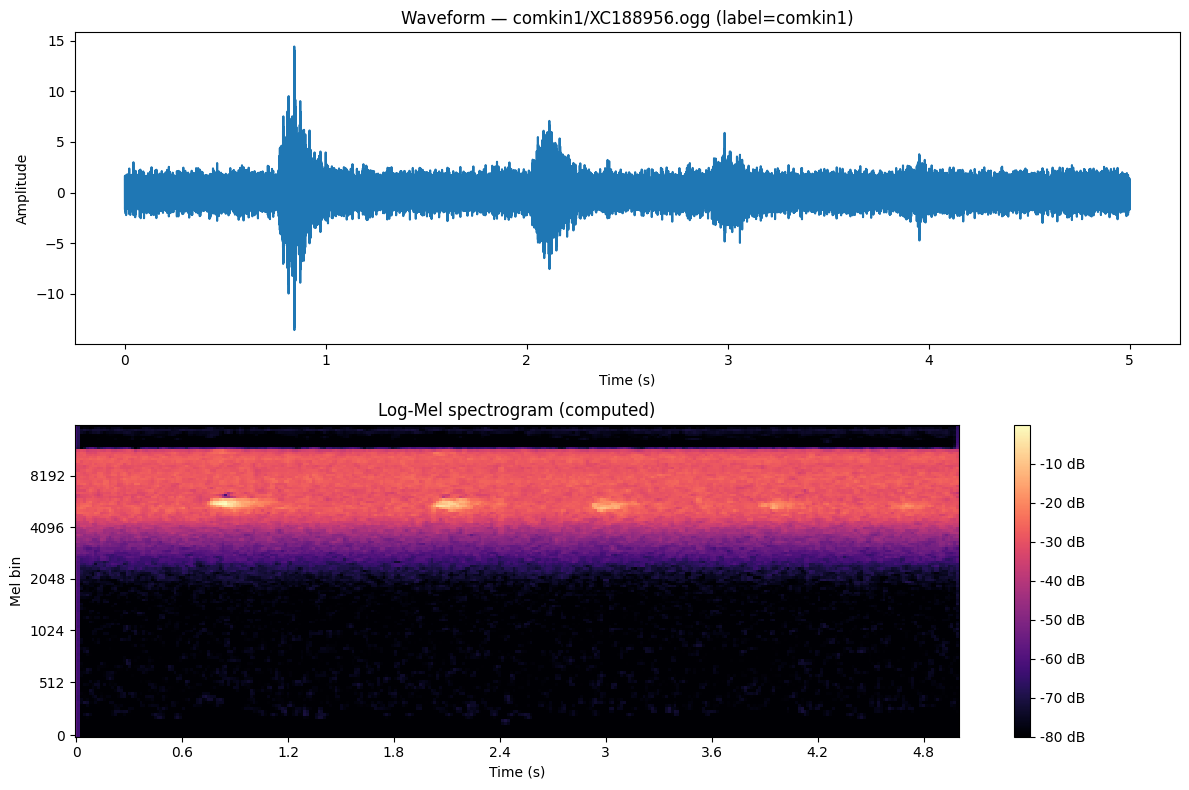

In [44]:
# choose a sample from your train_df metadata (or pick an explicit filename)
sample_row = train_df.sample(1, random_state=42).iloc[0]   # uses your train_df
audio_path = Path('/kaggle/input/birdclef-2024/train_audio') / sample_row['filename']

# load + fix length using your helper
y = load_and_fix_length(audio_path, sr=SR, target_sec=TARGET_SEC)

# compute mel using your helper
mel = extract_log_mel(y, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS)

# time axes (not required by specshow but useful for waveform)
t_wave = np.linspace(0, TARGET_SEC, len(y))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# waveform
axes[0].plot(t_wave, y)
axes[0].set_title(f"Waveform — {sample_row['filename']} (label={sample_row['primary_label']})")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")

# mel spectrogram
# capture the returned mappable into the variable `mappable`
mappable = librosa.display.specshow(
    mel,
    sr=SR,
    hop_length=HOP,
    x_axis='time',
    y_axis='mel',
    ax=axes[1],
    fmax=SR // 2
)
axes[1].set_title("Log-Mel spectrogram (computed)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Mel bin")

# create colorbar from the captured mappable object (robust)
fig.colorbar(mappable, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

# **Inception V1**

In [45]:
train_csv = OUT_DIR / 'train_features_top10_balanced_by_maxclass.csv'
val_csv   = OUT_DIR / 'val_features_top10.csv'
test_csv = OUT_DIR / 'test_features_top10.csv'

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df   = pd.read_csv(test_csv)

# converting single-channel features → 3-channel image

In [46]:
def mel_to_3channel_image(mel):
    d1 = librosa.feature.delta(mel)
    d2 = librosa.feature.delta(mel, order=2)
    image = np.stack([mel, d1, d2], axis=0)  # (3, 128, T)
    return image

In [47]:
preprocess = transforms.Compose([
    transforms.ToTensor(),                # (H, W, 3) → (3, H, W)
    transforms.Resize((224, 224)),        # GoogLeNet input size
    transforms.Normalize(                 # ImageNet Normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [48]:
def create_dataset(df):
    images = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        mel = np.load(row["feature_path"])    # shape = (128, T)

        img = mel_to_3channel_image(mel)      # (3, 128, T)

        # normalize 0-1
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # transpose to (H, W, 3) for transforms
        img = np.transpose(img, (1, 2, 0))    # (128, T, 3)

        # apply torchvision transforms
        img = preprocess(img).numpy()         # (3, 224, 224)

        images.append(img)
        labels.append(row["primary_label"])

    return np.array(images), np.array(labels)

In [49]:
X_train, y_train = create_dataset(train_df)
X_val,   y_val   = create_dataset(val_df)
X_test,  y_test  = create_dataset(test_df)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/995 [00:00<?, ?it/s]

In [50]:
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val   = le.transform(y_val)
y_test  = le.transform(y_test)
num_classes = len(le.classes_)

print("Number of classes:", num_classes)

Number of classes: 10


In [51]:
print("PyTorch version:", torch.__version__)
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor   = torch.FloatTensor(X_val)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor   = torch.LongTensor(y_val)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

PyTorch version: 2.6.0+cu124


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np

# Check if you're in PyTorch environment
print(f"PyTorch version: {torch.__version__}")
# # Load pretrained GoogLeNet (InceptionV1)
model = models.googlenet(pretrained=True)

# Modify the final layer for your 10 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Change to 10 output classes

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for batching
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs =15
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()
    
    # Print epoch results
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Acc: {val_acc:.2f}%')

PyTorch version: 2.6.0+cu124


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15:
Train Loss: 0.9918, Train Acc: 68.24%
Val Acc: 35.33%
Epoch 2/15:
Train Loss: 0.6108, Train Acc: 81.22%
Val Acc: 46.90%
Epoch 3/15:
Train Loss: 0.5019, Train Acc: 84.38%
Val Acc: 53.10%
Epoch 4/15:
Train Loss: 0.4299, Train Acc: 86.88%
Val Acc: 74.79%
Epoch 5/15:
Train Loss: 0.3816, Train Acc: 88.32%
Val Acc: 70.45%
Epoch 6/15:
Train Loss: 0.3192, Train Acc: 90.26%
Val Acc: 77.17%
Epoch 7/15:
Train Loss: 0.2443, Train Acc: 92.38%
Val Acc: 73.35%
Epoch 8/15:
Train Loss: 0.2306, Train Acc: 92.98%
Val Acc: 73.86%
Epoch 9/15:
Train Loss: 0.2155, Train Acc: 93.08%
Val Acc: 78.93%
Epoch 10/15:
Train Loss: 0.2154, Train Acc: 93.34%
Val Acc: 73.04%
Epoch 11/15:
Train Loss: 0.1654, Train Acc: 94.84%
Val Acc: 71.49%
Epoch 12/15:
Train Loss: 0.1623, Train Acc: 94.54%
Val Acc: 70.66%
Epoch 13/15:
Train Loss: 0.1474, Train Acc: 95.36%
Val Acc: 69.83%
Epoch 14/15:
Train Loss: 0.1195, Train Acc: 96.28%
Val Acc: 73.55%
Epoch 15/15:
Train Loss: 0.1507, Train Acc: 95.20%
Val Acc: 76.76%


Could not load saved model (continuing with current model in memory): [Errno 2] No such file or directory: 'best_googlenet_model.pth'
Test Accuracy: 76.88%

Per-class Precision / Recall / F1 / Support:
 0 blrwar1              | P: 0.833  R: 0.714  F1: 0.769  Support: 91
 1 comgre               | P: 0.906  R: 0.786  F1: 0.842  Support: 98
 2 comkin1              | P: 0.787  R: 0.833  F1: 0.810  Support: 102
 3 eurcoo               | P: 0.717  R: 0.689  F1: 0.703  Support: 103
 4 graher1              | P: 0.720  R: 0.651  F1: 0.684  Support: 83
 5 grewar3              | P: 0.620  R: 0.952  F1: 0.751  Support: 84
 6 grnsan               | P: 0.854  R: 0.843  F1: 0.848  Support: 83
 7 hoopoe               | P: 0.850  R: 0.708  F1: 0.773  Support: 120
 8 houspa               | P: 0.907  R: 0.752  F1: 0.822  Support: 129
 9 litgre1              | P: 0.614  R: 0.794  F1: 0.692  Support: 102

Weighted averages:
Precision (weighted): 0.787
Recall (weighted):    0.769
F1 (weighted):        0.771

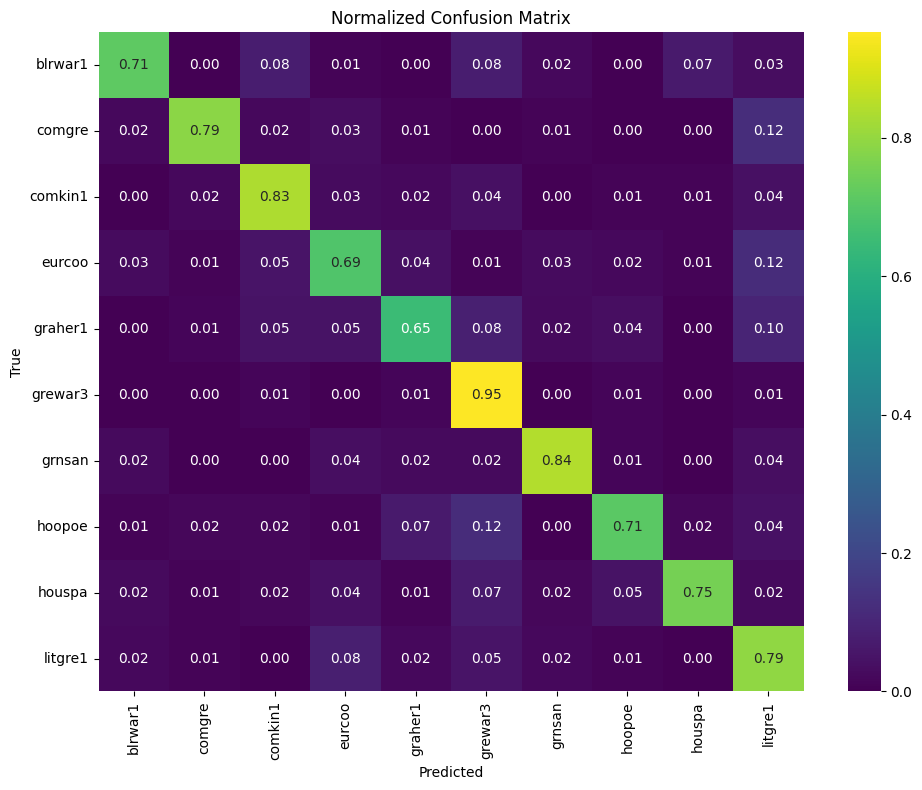

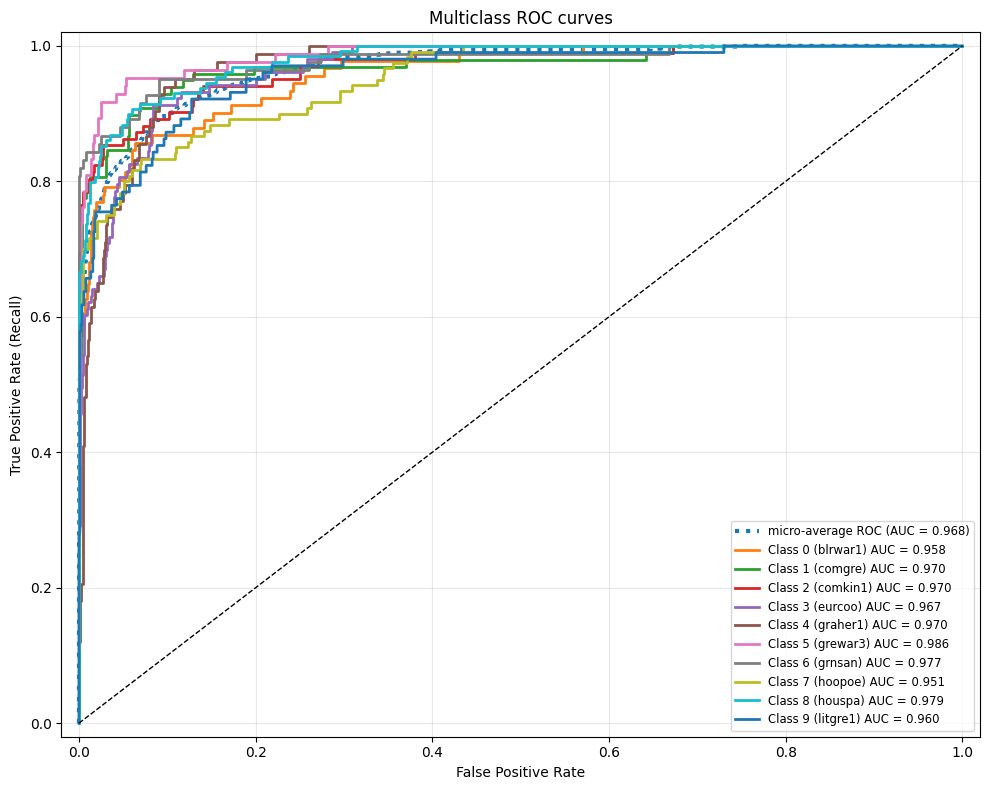


Micro-average AUC: 0.968
Macro-average AUC: 0.969
Class 0 (blrwar1): AUC = 0.958
Class 1 (comgre): AUC = 0.970
Class 2 (comkin1): AUC = 0.970
Class 3 (eurcoo): AUC = 0.967
Class 4 (graher1): AUC = 0.970
Class 5 (grewar3): AUC = 0.986
Class 6 (grnsan): AUC = 0.977
Class 7 (hoopoe): AUC = 0.951
Class 8 (houspa): AUC = 0.979
Class 9 (litgre1): AUC = 0.960


In [58]:
# -----------------------------
# EVALUATION ON TEST SET
# -----------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Make a test DataLoader (you created X_test, y_test earlier)
X_test_tensor  = torch.FloatTensor(X_test)     # shape (N, 3, 224, 224)
y_test_tensor  = torch.LongTensor(y_test)      # numeric labels (0..num_classes-1)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load best model (if you saved it)
# If the model in memory is already the best one you saved earlier, this is optional:
try:
    model.load_state_dict(torch.load("best_googlenet_model.pth", map_location=device))
    model = model.to(device)
    print("Loaded best_googlenet_model.pth")
except Exception as e:
    print("Could not load saved model (continuing with current model in memory):", e)

model.eval()
all_preds = []
all_probs = []
all_targets = []

softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        out = model(data)              # raw logits, shape (batch, num_classes)
        probs = softmax(out).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(target.numpy())

# concatenate
all_probs = np.vstack(all_probs)      # shape (N, num_classes)
all_preds = np.concatenate(all_preds) # shape (N,)
all_targets = np.concatenate(all_targets) # shape (N,)

# Basic metrics: Accuracy, Precision/Recall/F1
acc = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {acc*100:.2f}%\n")

# Per-class precision/recall/f1 + support
precision, recall, f1, support = precision_recall_fscore_support(
    all_targets, all_preds, average=None, labels=range(num_classes)
)

# Weighted averages
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_targets, all_preds, average='weighted'
)

print("Per-class Precision / Recall / F1 / Support:")
for i, cls_name in enumerate(le.classes_):
    print(f"{i:2d} {cls_name:20s} | P: {precision[i]:.3f}  R: {recall[i]:.3f}  F1: {f1[i]:.3f}  Support: {support[i]}")

print("\nWeighted averages:")
print(f"Precision (weighted): {prec_w:.3f}")
print(f"Recall (weighted):    {rec_w:.3f}")
print(f"F1 (weighted):        {f1_w:.3f}\n")

print("Full classification report:\n")
print(classification_report(all_targets, all_preds, target_names=le.classes_))

# Confusion matrix (normalized)
cm = confusion_matrix(all_targets, all_preds, labels=range(num_classes))
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='viridis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =========================
# ROC curve & AUC (multiclass)
# =========================
# Binarize the output labels for multiclass ROC
y_test_binarized = label_binarize(all_targets, classes=range(num_classes))  # shape (N, num_classes)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average AUC using sklearn's roc_auc_score where possible
# Note: roc_auc_score for multiclass expects shape (n_samples, n_classes) for scores
try:
    roc_auc["macro"] = roc_auc_score(y_test_binarized, all_probs, average="macro", multi_class="ovr")
except Exception as e:
    # fallback: average per-class AUCs
    roc_auc["macro"] = np.mean([roc_auc[i] for i in range(n_classes)])
    print("roc_auc_score multi-class raised:", e, "-> using mean(per-class AUC) as macro AUC")

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.3f})', linestyle=':', linewidth=3)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {i} ({le.classes_[i]}) AUC = {roc_auc[i]:.3f}')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Multiclass ROC curves')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary AUCs
print(f"\nMicro-average AUC: {roc_auc['micro']:.3f}")
print(f"Macro-average AUC: {roc_auc['macro']:.3f}")
for i in range(n_classes):
    print(f"Class {i} ({le.classes_[i]}): AUC = {roc_auc[i]:.3f}")